In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import names as input list:
lines_list = []
with open("/kaggle/input/makemore-names-txt/names.txt") as file:
    lines_list = [line.strip() for line in file]

In [3]:
# prepare vocab
vocab_list = sorted(list(set(''.join(lines_list))))
itos = {}
stoi = {}
for i in range(1,27):
    itos.update({i: vocab_list[i-1]})
itos[0] = '.'
stoi = {i:j for j, i in itos.items()}
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# prepare dataset of input and output characters (bigram)
dataset_x_list = []
dataset_y_list = []
context_size = 3
batch_size = 32
n_hidden = 200
vocab_size = len(itos)
for name in lines_list:
    context = [0]*context_size
    for i in (list(name) + ['.']):
        iy = stoi[i]
        dataset_x_list.append(context)
        dataset_y_list.append(iy)
        # print(''.join(itos[k] for k in context), i)
        context = context[1:] + [iy]
print(len(dataset_x_list), len(dataset_y_list))
# print([(i, j) for i, j in zip(dataset_x_list, dataset_y_list)])

228146 228146


In [5]:
# layers and parameters
X = torch.tensor(dataset_x_list)
Y = torch.tensor(dataset_y_list)
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([228146, 3]) torch.int64 torch.Size([228146]) torch.int64


In [6]:
# initialize embeddings table
n_embed = 10
C = torch.randn([vocab_size, n_embed])

In [7]:
# initial weights and biases
# first layer
W1 = torch.randn((context_size*n_embed, n_hidden))
B1 = torch.randn(n_hidden)
# second layer
W2 = torch.randn((n_hidden, vocab_size))
B2 = torch.randn(vocab_size)

# batch norm params
# learned
bn_gain = torch.ones(n_hidden, requires_grad=True)
bn_bias = torch.zeros(n_hidden, requires_grad=True)
# running
bn_running_mean = torch.zeros(n_hidden)
bn_running_var = torch.zeros(n_hidden)
bn_eps = 1e-5
bn_momentum = 0.1

# gather all param
parameters = [C, W1, B1, W2, B2, bn_gain, bn_bias]
learning_rate = 0.1

In [8]:
# set grad true for all params
for p in parameters:
    p.requires_grad = True

In [9]:
# learning rate (dynamic)
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [10]:
# lists to store loss and steps
lossl = []
lrsl = []

In [11]:
# forward pass
for i in range(30000):
    # mini batch
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    hpre = emb.view(-1,context_size*n_embed) @ W1 + B1
    # batch statistics for normalization
    bn_mean = hpre.mean(0, keepdim=True)
    bn_var = hpre.var(0, keepdim=True, unbiased=False)
    # normalize
    hpre_norm = (hpre - bn_mean)/torch.sqrt(bn_var + bn_eps)
    # scale and shift
    hpre_bn = bn_gain * hpre_norm + bn_bias
    # update running stats (no gradients)
    with torch.no_grad():
        bn_running_mean = (1 - bn_momentum) * bn_running_mean + bn_momentum * bn_mean.squeeze()
        bn_running_var  = (1 - bn_momentum) * bn_running_var  + bn_momentum * bn_var.squeeze()
    h = torch.tanh(hpre_bn)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    # calculate gradients
    loss.backward()
    # udpate params based on gradients
    lr = 0.01
    for p in parameters:
        p.data += -lr* p.grad
    lrsl.append(i)
    lossl.append(loss.item())

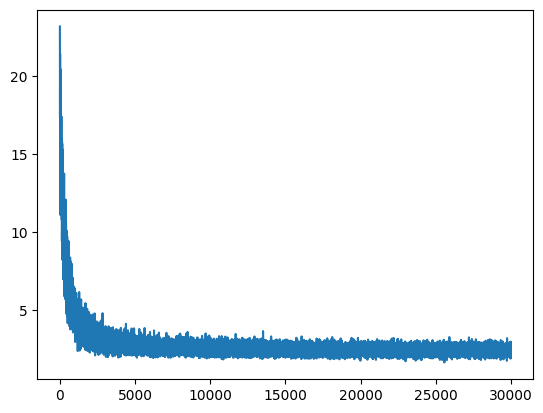

In [12]:
plt.plot(lrsl, lossl)

In [13]:
loss.item()

2.331416368484497

In [14]:
# sample
g = torch.Generator().manual_seed(343439843 + 10)
for _ in range(20):
    out = []
    context = [0] * context_size
    # print(context)
    while True:
        emb = C[torch.tensor([context])]
        # print(emb.shape)
        hpre = emb.view(1, -1) @ W1 + B1
        hpre_norm = (hpre - bn_running_mean)/torch.sqrt(bn_running_var + bn_eps)
        hpre_bn = bn_gain * hpre_norm + bn_bias
        h = torch.tanh(hpre_bn)
        logits = h @ W2 + B2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[k] for k in out))

kandayeyntia.
rrorhingad.
hepgeba.
jusona.
tavyva.
duie.
sovy.
jaxmahsad.
derghan.
ziaavanniah.
rur.
nytlon.
halygio.
hhzayra.
thon.
kevolenaryvangalaekathenyh.
brolowaetla.
ahmrtxon.
pfe.
mudhelokkamile.
